In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

[Random Fourier Features](https://gregorygundersen.com/blog/2019/12/23/random-fourier-features/) - blog post

[Reconciling modern machine-learning practice and the classical bias–variance trade-off](https://www.pnas.org/content/pnas/116/32/15849.full.pdf) - paper

# Synthetic objective function

In [2]:
def objective_function(x, noise=False):
    a = np.sin(2*x)
    b = np.cos(x/2)
    c = -np.abs(x)/3
    d = -5*np.cos(x/5)
    e = (x/5)+5
    if noise:
        eta = np.random.randn(*x.shape)/3
    else:
        eta = 0
    return a+b+c+d+e+eta

In [3]:
x_train = np.random.uniform(-10, 10, 100)
y_train = objective_function(x_train, True)

In [4]:
x_test = np.linspace(-10, 10, 500)
y_test = objective_function(x_test, False)

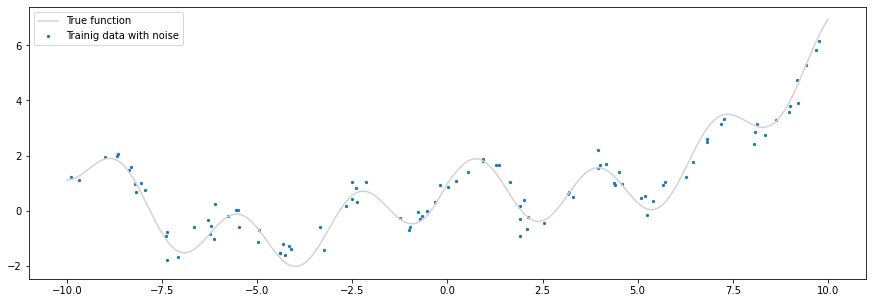

In [5]:
fig = plt.figure(figsize=[15, 5])
ax = fig.gca()
ax.plot(x_test, y_test, c="lightgrey", label="True function")
ax.scatter(x_train, y_train, s=5, label="Trainig data with noise")
ax.legend()

# RFF process

RFF function
$$
h(x) = \sum_{k=1}^{N}\alpha_{k} \phi(x; v_{k}) \quad \text{where} \quad \phi(x; v_{k}):=e^{\sqrt{-1}} \langle v_{k}, x \rangle
$$
and
$$
v_i \sim \mathcal{N}(0, 1)
$$


In [6]:
def phi(x, v):
    return np.exp(1j*np.dot(v, x.T))

$$\bar{h} = \Phi\bar{\alpha}$$

where
$$
\bar{v} = \{v_1, v_2, \cdots, v_n\}
$$
$$\Phi =
\begin{bmatrix}
\phi(x_1, v_1) & \phi(x_1, v_2) & \cdots &  \phi(x_1, v_n)\\
\phi(x_2, v_1) & \phi(x_2, v_2) & \cdots &  \phi(x_2, v_n)\\
\vdots & \vdots & \ddots & \vdots \\
\phi(x_m, v_1) & \phi(x_m, v_2) & \cdots & \phi(x_m, v_n)
\end{bmatrix}
$$


In [7]:
## train model
N = 10 # number of random Fourier features
d = 1 # number of parameters in xi 

# random vector of v values
V = np.random.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), size=N)

# generate Phi matrix
Phi = np.zeros((len(x_train), len(V)), dtype='complex')
for i, x in enumerate(x_train):
    x = x.reshape(1,-1)
    for j, v in enumerate(V):
        v = v.reshape(1,-1)
        Phi[i, j] = phi(x, v)

model cost function is given by
$$
\begin{equation}
\begin{aligned}
\frac{1}{n}\sum^{n}_{i=1}\big(h(x_{i})-y_{i} \big)\\
\end{aligned}
\end{equation}
$$
to fit the model we must find $\bar{\alpha}$ to minimise $E$ given $\bar{x}, \bar{y} \in \mathcal{D}_{train}$:
$$
\begin{equation}
\begin{aligned}
E(\bar{\alpha}|\bar{x}, \bar{y}) &= (\bar{y} - \Phi\bar{\alpha})^{\intercal}(\bar{y} - \Phi\bar{\alpha})\\
\end{aligned}
\end{equation}
$$

minimum when
$$
\begin{equation}
\begin{aligned}
\frac{\partial E}{\partial \bar{\alpha}} &= 0 \\
\frac{\partial E}{\partial \bar{\alpha}} &= \Phi^{\intercal}\Phi\bar{\alpha}-\Phi^{\intercal}\bar{y}\\
\Phi^{\intercal}\Phi\bar{\alpha}&=\Phi^{\intercal}\bar{y}\\
\bar{\alpha} &= (\Phi^{\intercal}\Phi)^{-1}\Phi^{\intercal}\bar{y}\\
\bar{\alpha} &\equiv \Phi^{\dagger}\bar{y}
\end{aligned}
\end{equation}
$$
where $\dagger$ indicates the pseudo-inverse

and $\bar{y}$ are the target points

In [8]:
# fit alpha to training data
alpha = np.linalg.pinv(Phi)@y_train.T
alpha = alpha.reshape(1,-1)
alpha.shape

(1, 10)

predictions made using the trained $\bar{\alpha}$:
$$\bar{h} = \Phi_{test}\bar{\alpha}$$
as described above. Where:
$$
\Phi_{test} =
\begin{bmatrix}
\phi(x_1, v_1) & \phi(x_1, v_2) & \cdots &  \phi(x_1, v_n)\\
\phi(x_2, v_1) & \phi(x_2, v_2) & \cdots &  \phi(x_2, v_n)\\
\vdots & \vdots & \ddots & \vdots \\
\phi(x_m, v_1) & \phi(x_m, v_2) & \cdots & \phi(x_m, v_n)
\end{bmatrix}
$$
where $\Phi_{test}$ is generated for the testing data $x_i \in \bar{x}_{test}$

In [9]:
## test model
Phi_test = np.zeros((len(x_test), len(V)), dtype='complex')
for i, x in enumerate(x_test):
    for j, v in enumerate(V):
        Phi_test[i, j] = phi(x, v)

# make predictions
predictions = Phi_test@alpha.T

/home/finley/miniconda3/envs/testsuite/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


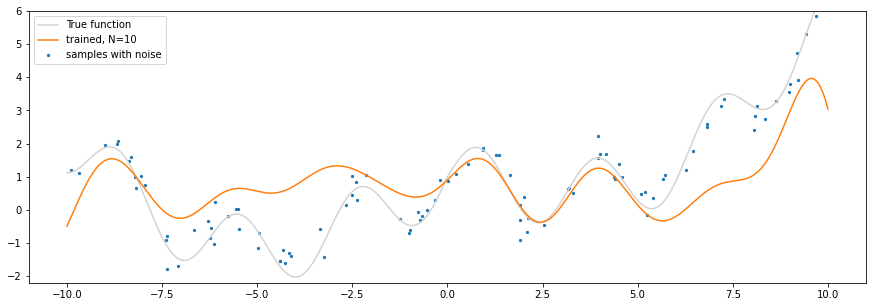

In [10]:
# plot predictions
fig = plt.figure(figsize=[15, 5])
ax = fig.gca()
ax.plot(x_test, y_test, c="lightgrey", label="True function")
ax.scatter(x_train, y_train, s=5, c="C0", label="samples with noise")
ax.plot(x_test, predictions, c="C1", label="trained, N={}".format(int(N)))
ax.set_ylim([-2.2, 6])
ax.legend()

# Functions

In [11]:
# define functions to do the training and testing for any given N 

def train_model(x, y, V):
    """
    returns alpha to fit trainig observations (x, y) with N random Fourier features
    
    params:
        x np.array([n_data, n_dim]): training data, parameters
        y np.array([n_data, n_dim]): training data, observed objective response 
        N [int]: number of RFF to use
        
    returns:
        alpha np.array([N, 1]): alpha values
    """
    N = V.shape[0]
    assert x.shape[0] == y.shape[0]
    if x.ndim == 1:
        x = x.reshape(-1,1)
    if y.ndim == 1:
        y = y.reshape(-1,1)
        
    n_data = x.shape[0]
    ## train model
    d = x.shape[1] # number of parameters in xi 
    
    # generate Phi matrix
    Phi = np.zeros((n_data, N), dtype='complex')
    for i, x in enumerate(x):
        for j, v in enumerate(V):
            Phi[i, j] = phi(x, v)
    # fit alpha to training data
    alpha = np.linalg.pinv(Phi)@y
    return alpha

def predict(x, alpha, V):
    N = V.shape[0]
    if x.ndim == 1:
        x = x.reshape(-1,1)
    Phi_test = np.zeros((x.shape[0], N), dtype='complex')
    for i, x in enumerate(x):
        for j, v in enumerate(V):
            Phi_test[i, j] = phi(x, v)
    
    # make predictions
    predictions = Phi_test@alpha
    return predictions

# Example N 

In [21]:
N = 20
x_train = np.random.uniform(-10, 10, 100).reshape(-1,1)
y_train = objective_function(x_train, True).reshape(-1,1)
x_train = x_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)
V = np.random.multivariate_normal(np.zeros(x_train.shape[1]), np.diag(np.ones(x_train.shape[1])), size=N)
V.shape

(20, 1)

In [22]:
a = train_model(x_train, y_train, V)

In [23]:
x_test = np.linspace(x_train.min(), x_train.max(), 500).reshape(-1,1)
y_test = objective_function(x_test)
print(x_test.shape)
preds = predict(x_test, a, V)

(500, 1)


/home/finley/miniconda3/envs/testsuite/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


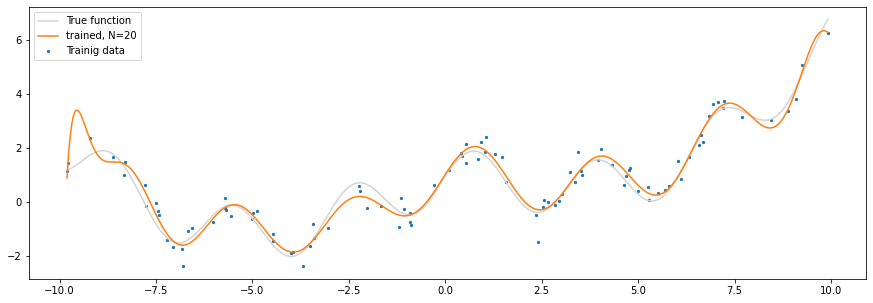

In [24]:
fig = plt.figure(figsize=[15, 5])
ax = fig.gca()
ax.plot(x_test, y_test, c="lightgrey", label="True function")
ax.scatter(x_train, y_train, s=5, label="Trainig data")
ax.plot(x_test, preds, c="C1", label="trained, N={}".format(int(N)))
ax.legend()

# Search over N

In [16]:
# evaluate over a range of N.
## WARNING takes time
losses = []
ns = range(1, 500, 10)

# for N in ns:
for N in tqdm(ns): # comment out and use line above to circumvent tqdm
    V = np.random.multivariate_normal(np.zeros(x_train.shape[1]), np.diag(np.ones(x_train.shape[1])), size=N)
    a = train_model(x_train, y_train, V) 
    preds = predict(x_test, a, V)
    loss = np.sum((preds -y_test)**2)
    losses.append(loss)

100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


Text(0, 0.5, '$E(\\alpha)$')

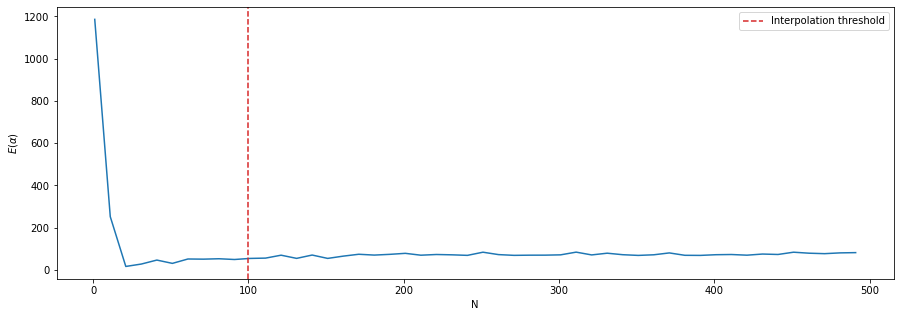

In [17]:
fig = plt.figure(figsize=[15, 5])
ax = fig.gca()
ax.plot(ns, losses)
ax.axvline(x_train.shape[0],  c="C3", linestyle="--", label="Interpolation threshold")
ax.legend()
ax.set_xlabel('N')
ax.set_ylabel(r'$E(\alpha)$')